In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import yaml
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

data = config['paths']['data']
figure = config['paths']['figure']
model = config['paths']['model']

In [3]:
df = pd.read_csv(data)
df.head(5)

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [4]:
df.shape

(13200, 11)

# Feature Engineering

In [5]:
def remove_outliers(df):
    cleaned_df = df.copy()
    for col in cleaned_df.columns:
        if cleaned_df[col].dtype in ['float64', 'int64']:

            Q1 = cleaned_df[col].quantile(0.25)
            Q3 = cleaned_df[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_limit = Q1 - 1.5 * IQR
            upper_limit = Q3 + 1.5 * IQR

            cleaned_df[col] = cleaned_df[col].apply(
                lambda x: x if pd.isnull(x) or (lower_limit <= x <= upper_limit) else None
            )
    
    return cleaned_df

df = remove_outliers(df)

In [6]:
num_feat = [feature for feature in df.columns if df[feature].dtype != 'O']
cate_feat = [feature for feature in df.columns if df[feature].dtype == 'O']

In [7]:
df['Weather Type'] = LabelEncoder().fit_transform(df['Weather Type'])
df['Weather Type']

0        1
1        0
2        3
3        3
4        1
        ..
13195    1
13196    2
13197    0
13198    2
13199    1
Name: Weather Type, Length: 13200, dtype: int64

In [8]:
cate_feat.remove('Weather Type')
print(cate_feat)

['Cloud Cover', 'Season', 'Location']


In [9]:
import os

transformer = ColumnTransformer([
    ('scaler', StandardScaler(), num_feat),
    ('encoder', OneHotEncoder(dtype=int), cate_feat)
])

joblib.dump(transformer, os.path.join(model, 'transformer.pkl'))

['D:/Workspace/Research_Fields/Atmospheric_Data_Visualization/Weather_Classification/model\\transformer.pkl']

# Data Partitioning

In [10]:
df.dropna(inplace=True, axis=0)

In [11]:
y = df['Weather Type']
X = df.drop(columns=['Weather Type'])

X = transformer.fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(9351, 18)
(2338, 18)


# Model Training

In [13]:
def param_tuning(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    rf_classifier = RandomForestClassifier(random_state=42)
    
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    return best_params, best_model

In [14]:
rf_param, rf_model = param_tuning(X_train, y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estim

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1620 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "d:\Workspace\Research_Fields\Atmospheric_Data_Visualiza

In [15]:
rf_model.score(X_train, y_train)

0.9971126082771896

In [16]:
rf_model.score(X_test, y_test)

0.9751924721984602

In [17]:
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_true=y_test, y_pred=rf_pred)
rf_pre = precision_score(y_true=y_test, y_pred=rf_pred, average='weighted')
rf_rec = recall_score(y_true=y_test, y_pred=rf_pred, average='weighted')
rf_f1 = f1_score(y_true=y_test, y_pred=rf_pred, average='weighted')

In [18]:
def param_tuning(X_train, y_train):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4]
    }
    
    svm_classifier = SVC()
    
    grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=3)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    return best_params, best_model


In [19]:
svc_param, svc_model = param_tuning(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.959 total time=   0.1s
[CV 2/5] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.960 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.961 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.960 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=scale, kernel=linear;, score=0.959 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=scale, kernel=poly;, score=0.963 total time=   0.1s
[CV 2/5] END C=0.1, degree=2, gamma=scale, kernel=poly;, score=0.965 total time=   0.1s
[CV 3/5] END C=0.1, degree=2, gamma=scale, kernel=poly;, score=0.963 total time=   0.1s
[CV 4/5] END C=0.1, degree=2, gamma=scale, kernel=poly;, score=0.964 total time=   0.1s
[CV 5/5] END C=0.1, degree=2, gamma=scale, kernel=poly;, score=0.961 total time=   0.1s
[CV 1/5] END C=0.1, degree=2, gamma=scale, ker

In [20]:
svc_model.score(X_train, y_train)

0.9879157309378676

In [21]:
svc_model.score(X_test, y_test)

0.9730538922155688

In [22]:
svc_pred = svc_model.predict(X_test)
svc_acc = accuracy_score(y_true=y_test, y_pred=svc_pred)
svc_pre = precision_score(y_true=y_test, y_pred=svc_pred, average='weighted')
svc_rec = recall_score(y_true=y_test, y_pred=svc_pred, average='weighted')
svc_f1 = f1_score(y_true=y_test, y_pred=svc_pred, average='weighted')

In [23]:
def param_tuning(X_train, y_train):
    param_grid = {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    }
    
    nb_classifier = GaussianNB()
    
    grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    return best_params, best_model

In [24]:
nb_param, nb_model = param_tuning(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-09; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-08; total time=   0.0s
[CV] END ................................var_smoothing=1e-07; total time=   0.0s
[CV] END ................................var_smoo

In [25]:
nb_model.score(X_train, y_train)

0.9349802160196771

In [26]:
nb_model.score(X_test, y_test)

0.9422583404619332

In [27]:
nb_pred = nb_model.predict(X_test)
nb_acc = accuracy_score(y_true=y_test, y_pred=nb_pred)
nb_pre = precision_score(y_true=y_test, y_pred=nb_pred, average='weighted')
nb_rec = recall_score(y_true=y_test, y_pred=nb_pred, average='weighted')
nb_f1 = f1_score(y_true=y_test, y_pred=nb_pred, average='weighted')

In [28]:
def param_tuning(X_train, y_train):
    param_grid = {
        'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
        'penalty': ['none', 'l2', 'l1', 'elasticnet'],
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
        'max_iter': [1000, 2000, 3000],
        'tol': [1e-3, 1e-4, 1e-5]
    }
    
    sgd_classifier = SGDClassifier(random_state=42)
    
    grid_search = GridSearchCV(estimator=sgd_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    return best_params, best_model

In [29]:
sgd_param, sgd_model = param_tuning(X_train, y_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=1000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=1000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, learning_rate=constant, loss=hinge, max_iter=1000, penalty=none, tol=0.0001; total 

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.4s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.4s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.4s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.3s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=1e-05; total time=   0.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=1e-05; total time=   0.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=1e-05; total time=   0.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=1e-05; total time=   0.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=1e-05; total time=   0.8s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=e

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=l1, tol=1e-05; total time=   0.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=l1, tol=1e-05; total time=   0.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=l1, tol=1e-05; total time=   1.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=l1, tol=1e-05; total time=   0.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=l1, tol=1e-05; total time=   1.6s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=e

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=l1, tol=1e-05; total time=   1.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=l1, tol=1e-05; total time=   1.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=l1, tol=1e-05; total time=   1.8s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=l1, tol=1e-05; total time=   0.9s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=l1, tol=1e-05; total time=   2.3s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=elasticnet, tol=0.

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.4s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.1s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.3s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.4s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.1s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.4s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.7s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.3s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.5s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.4s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticne

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   2.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   2.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   2.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.5s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.3s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.5s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.4s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticne

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   3.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   5.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   4.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   3.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   5.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   4.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   3.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   5.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   4.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   4.7s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.3s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.5s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.4s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.0001; total time=   0.2s
[CV] END alpha=0.001, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticne

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=1e-05; total time=   0.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=1e-05; total time=   0.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=1e-05; total time=   0.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=1e-05; total time=   0.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=l1, tol=1e-05; total time=   0.6s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=1000, penalty=elasticne

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=l1, tol=1e-05; total time=   0.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=l1, tol=1e-05; total time=   0.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=l1, tol=1e-05; total time=   1.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=l1, tol=1e-05; total time=   0.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=l1, tol=1e-05; total time=   1.1s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=2000, penalty=elasticne

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=l1, tol=1e-05; total time=   1.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=l1, tol=1e-05; total time=   1.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=l1, tol=1e-05; total time=   1.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=l1, tol=1e-05; total time=   1.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=l1, tol=1e-05; total time=   1.5s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=elasticnet, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=modified_huber, max_iter=3000, penalty=elasticne

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=1e-05; total time=   1.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=1e-05; total time=   1.6s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.001; total time=   1.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.0001; total time=   1.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.0001; total time=   1.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.0001; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=1e-05; total time=   1.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=1e-05; total time=   1.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=1e-05; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=1e-05; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=1e-05; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=1e-05; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=1e-05; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=1e-05; total time=   3.2s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.001; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.001; total time=   2.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.001; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.001; total time=   2.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.001; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.0001; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.0001; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.0001; total time=   2.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.0001; total time=   2.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.0001; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=1e-05; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=1e-05; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=1e-05; total time=   2.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=1e-05; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=1e-05; total time=   2.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   4.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   4.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   4.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   5.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   5.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   4.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   5.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   4.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   4.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.0001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.0001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.0001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.0001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.0001; total time=   4.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=1e-05; total time=   4.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=1e-05; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=1e-05; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=1e-05; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=1e-05; total time=   4.8s
[CV] END alpha=0.01, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, learning

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l2, tol=1e-05; total time=   0.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=l1, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   1.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   1.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.001; total time=   1.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   1.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   1.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=1e-05; total time=   1.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=1e-05; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=1000, penalty=elasticnet, tol=1e-05; total time=   1.6s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END alpha=0

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.001; total time=   1.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.001; total time=   0.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.001; total time=   1.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.0001; total time=   1.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.0001; total time=   1.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.0001; total time=   1.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=0.0001; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=1e-05; total time=   1.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=1e-05; total time=   1.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l2, tol=1e-05; total time=   1.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.001; total time=   3.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=0.0001; total time=   3.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=l1, tol=1e-05; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   2.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   3.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   2.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.001; total time=   2.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   2.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   3.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   2.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=0.0001; total time=   3.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=1e-05; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=1e-05; total time=   3.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=1e-05; total time=   3.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=1e-05; total time=   3.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=2000, penalty=elasticnet, tol=1e-05; total time=   3.2s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END alpha=0

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.001; total time=   1.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.001; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.001; total time=   2.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.001; total time=   1.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.001; total time=   1.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.0001; total time=   1.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.0001; total time=   2.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.0001; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.0001; total time=   1.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=0.0001; total time=   2.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=1e-05; total time=   1.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=1e-05; total time=   2.3s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=1e-05; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=1e-05; total time=   2.2s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l2, tol=1e-05; total time=   2.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   4.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   4.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   4.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   4.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=0.0001; total time=   4.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   4.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=l1, tol=1e-05; total time=   4.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   3.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   3.1s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.001; total time=   4.0s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.0001; total time=   3.5s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.0001; total time=   4.7s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.0001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.0001; total time=   3.9s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=0.0001; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=1e-05; total time=   3.6s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=1e-05; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=1e-05; total time=   4.8s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=1e-05; total time=   4.4s


d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, learning_rate=optimal, loss=squared_hinge, max_iter=3000, penalty=elasticnet, tol=1e-05; total time=   4.8s
[CV] END alpha=0.1, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=optimal, loss=perceptron, max_iter=1000, penalty=none, tol=0.0001; total time=   0.0s
[CV] END alpha=0.1, learning_rate=opt

d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
14625 fits failed out of a total of 18000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4500 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Workspace\Research_Fields\Atmospheric_Data_Visualization\adv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "d:\Workspace\Research_Fields\Atmospheric_Data_Visuali

In [30]:
sgd_model.score(X_train, y_train)

0.9401133568602289

In [31]:
sgd_model.score(X_test, y_test)

0.9443969204448246

In [32]:
sgd_pred = sgd_model.predict(X_test)
sgd_acc = accuracy_score(y_true=y_test, y_pred=sgd_pred)
sgd_pre = precision_score(y_true=y_test, y_pred=sgd_pred, average='weighted')
sgd_rec = recall_score(y_true=y_test, y_pred=sgd_pred, average='weighted')
sgd_f1 = f1_score(y_true=y_test, y_pred=sgd_pred, average='weighted')

In [33]:
def param_tuning(X_train, y_train):
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': np.logspace(-4, -1, 4),
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [200, 400, 600]
    }
    
    mlp_classifier = MLPClassifier(random_state=42, early_stopping=True, n_iter_no_change=10)
    
    grid_search = GridSearchCV(estimator=mlp_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    return best_params, best_model


In [34]:
mlp_param, mlp_model = param_tuning(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd; total time=   0.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=sgd; total time=   0.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=adam; total time=   0.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200, solver=adam; total ti

In [35]:
mlp_model.score(X_train, y_train)

0.9712330232060742

In [36]:
mlp_model.score(X_test, y_test)

0.9683490162532079

In [37]:
mlp_pred = mlp_model.predict(X_test)
mlp_acc = accuracy_score(y_true=y_test, y_pred=mlp_pred)
mlp_pre = precision_score(y_true=y_test, y_pred=mlp_pred, average='weighted')
mlp_rec = recall_score(y_true=y_test, y_pred=mlp_pred, average='weighted')
mlp_f1 = f1_score(y_true=y_test, y_pred=mlp_pred, average='weighted')

In [39]:
from sklearn.metrics import confusion_matrix

rf_cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
svc_cm = confusion_matrix(y_true=y_test, y_pred=svc_pred)
nb_cm = confusion_matrix(y_true=y_test, y_pred=nb_pred)
sgd_cm = confusion_matrix(y_true=y_test, y_pred=sgd_pred)
mlp_cm = confusion_matrix(y_true=y_test, y_pred=mlp_pred)

In [40]:
cm_list = [rf_cm, svc_cm, nb_cm, sgd_cm, mlp_cm]
model_names = ['Random Forest', 'Support Vector Machine', 'Naive Bayes', 'Stochastic Gradient Descent', 'Multi-layer Perceptron']

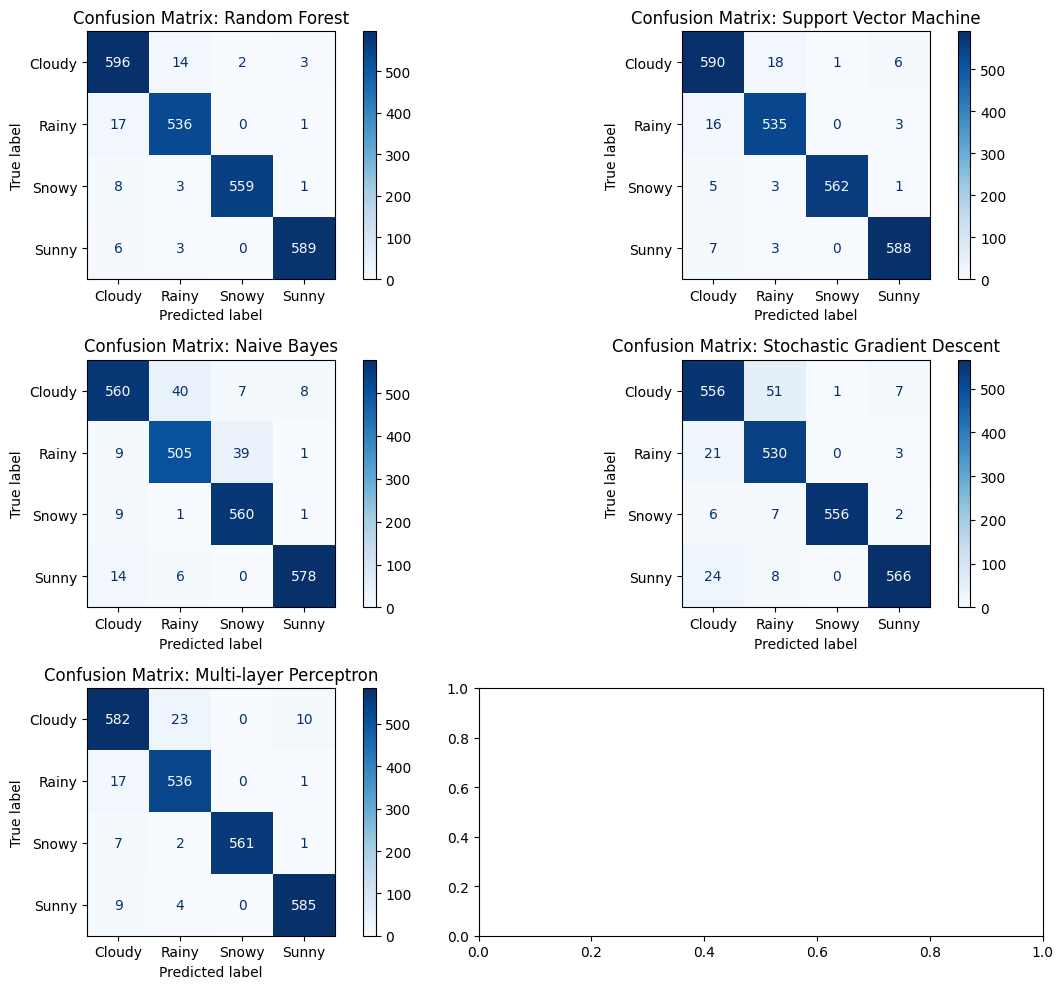

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
for ax, cm, name in zip(axes.flat, cm_list, model_names):
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cloudy', 'Rainy', 'Snowy', 'Sunny'])
    disp.plot(ax=ax, cmap='Blues')
    ax.set_title(f'Confusion Matrix: {name}')

plt.tight_layout()
plt.savefig(os.path.join(figure, 'Confusion_matrices.png'))
plt.show()

In [43]:
model_results = [
    {'model': 'RandomForestClassifier', 'accuracy': rf_acc, 'precision': rf_pre, 'f1_score': rf_f1, 'recall': rf_rec, 'param':rf_param},
    {'model': 'SVC', 'accuracy': svc_acc, 'precision': svc_pre, 'f1_score': svc_f1, 'recall': svc_rec, 'param':svc_param},
    {'model': 'GaussanNB', 'accuracy': nb_acc, 'precision': nb_pre, 'f1_score': nb_f1, 'recall': nb_rec, 'param':nb_param},
    {'model': 'SGDClassifier', 'accuracy': sgd_acc, 'precision': sgd_pre, 'f1_score': sgd_f1, 'recall': sgd_rec, 'param':sgd_param},
    {'model': 'MLPClassifier', 'accuracy': mlp_acc, 'precision': mlp_pre, 'f1_score': mlp_f1, 'recall': mlp_rec, 'param':mlp_param}
]

In [44]:
df_model_results = pd.DataFrame(model_results)
display(df_model_results)

,model,accuracy,precision,f1_score,recall,param
0,RandomForestClassifier,0.975192,0.975447,0.975274,0.975192,"{'bootstrap': True, 'max_depth': 20, 'max_feat..."
1,SVC,0.973054,0.973198,0.973108,0.973054,"{'C': 10, 'degree': 2, 'gamma': 'auto', 'kerne..."
2,GaussanNB,0.942258,0.942717,0.942175,0.942258,{'var_smoothing': 0.001}
3,SGDClassifier,0.944397,0.945910,0.944743,0.944397,"{'alpha': 0.01, 'learning_rate': 'optimal', 'l..."
4,MLPClassifier,0.968349,0.968582,0.968424,0.968349,"{'activation': 'relu', 'alpha': 0.1, 'hidden_l..."


In [45]:
df_model_results.to_csv('D:/Workspace/Research_Fields/Atmospheric_Data_Visualization/Weather_Classification/data/results.csv')